In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [2]:
# data wrangling: load Fashion-MNIST
FMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])



FMNIST_train = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=True,
        download=True,
        transform=FMNIST_transform)



FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=False,
        download=False,
        transform=FMNIST_transform)


100.0%

Extracting /Users/moreez/data/fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/moreez/data/fmnist/FashionMNIST/raw


27.8%

2.0%0%

Extracting /Users/moreez/data/fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/moreez/data/fmnist/FashionMNIST/raw


159.1%

Extracting /Users/moreez/data/fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/moreez/data/fmnist/FashionMNIST/raw
Extracting /Users/moreez/data/fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/moreez/data/fmnist/FashionMNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


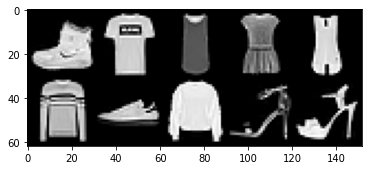

In [3]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = FMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [4]:
fmnist_train_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_train,
    batch_size=128,
    shuffle=True
)

fmnist_test_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [5]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [6]:
#set up the training routine
fmnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

fmnist_train_optimizer = torch.optim.Adam(fmnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
FMNIST_PATH = "FMNIST_weights_seed={}.pth".format(s)
#print(FMNIST_PATH)

In [7]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [8]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(fmnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(fmnist_train_loader):
            output = fmnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            fmnist_train_optimizer.step()
            fmnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(FMNIST_PATH))
    torch.save(fmnist_model.state_dict(), FMNIST_PATH)

In [9]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


Iteration 0; 0/469 	Minibatch Loss 2.312  Accuracy 14%
Iteration 0; 10/469 	Minibatch Loss 1.979  Accuracy 34%
Iteration 0; 20/469 	Minibatch Loss 1.385  Accuracy 56%
Iteration 0; 30/469 	Minibatch Loss 1.124  Accuracy 58%
Iteration 0; 40/469 	Minibatch Loss 0.889  Accuracy 67%
Iteration 0; 50/469 	Minibatch Loss 0.774  Accuracy 70%
Iteration 0; 60/469 	Minibatch Loss 0.804  Accuracy 70%
Iteration 0; 70/469 	Minibatch Loss 0.803  Accuracy 75%
Iteration 0; 80/469 	Minibatch Loss 0.840  Accuracy 69%
Iteration 0; 90/469 	Minibatch Loss 0.660  Accuracy 77%
Iteration 0; 100/469 	Minibatch Loss 0.737  Accuracy 71%
Iteration 0; 110/469 	Minibatch Loss 0.554  Accuracy 77%
Iteration 0; 120/469 	Minibatch Loss 0.537  Accuracy 80%
Iteration 0; 130/469 	Minibatch Loss 0.702  Accuracy 74%
Iteration 0; 140/469 	Minibatch Loss 0.634  Accuracy 80%
Iteration 0; 150/469 	Minibatch Loss 0.513  Accuracy 80%
Iteration 0; 160/469 	Minibatch Loss 0.752  Accuracy 75%
Iteration 0; 170/469 	Minibatch Loss 0.542

Iteration 3; 40/469 	Minibatch Loss 0.393  Accuracy 86%
Iteration 3; 50/469 	Minibatch Loss 0.294  Accuracy 88%
Iteration 3; 60/469 	Minibatch Loss 0.332  Accuracy 87%
Iteration 3; 70/469 	Minibatch Loss 0.380  Accuracy 88%
Iteration 3; 80/469 	Minibatch Loss 0.381  Accuracy 86%
Iteration 3; 90/469 	Minibatch Loss 0.244  Accuracy 91%
Iteration 3; 100/469 	Minibatch Loss 0.254  Accuracy 91%
Iteration 3; 110/469 	Minibatch Loss 0.290  Accuracy 89%
Iteration 3; 120/469 	Minibatch Loss 0.312  Accuracy 88%
Iteration 3; 130/469 	Minibatch Loss 0.219  Accuracy 91%
Iteration 3; 140/469 	Minibatch Loss 0.488  Accuracy 84%
Iteration 3; 150/469 	Minibatch Loss 0.325  Accuracy 91%
Iteration 3; 160/469 	Minibatch Loss 0.343  Accuracy 88%
Iteration 3; 170/469 	Minibatch Loss 0.340  Accuracy 85%
Iteration 3; 180/469 	Minibatch Loss 0.360  Accuracy 87%
Iteration 3; 190/469 	Minibatch Loss 0.382  Accuracy 86%
Iteration 3; 200/469 	Minibatch Loss 0.286  Accuracy 89%
Iteration 3; 210/469 	Minibatch Loss 

NameError: name 'mnist_model' is not defined

In [10]:
torch.save(fmnist_model.state_dict(), FMNIST_PATH)

In [11]:
#predict in distribution
FMNIST_PATH = "FMNIST_weights_seed={}.pth".format(s)

fmnist_model = NN(num_classes=10)
print("loading model from: {}".format(FMNIST_PATH))
fmnist_model.load_state_dict(torch.load(FMNIST_PATH))
fmnist_model.eval()

acc = []

max_len = len(fmnist_test_loader)
for batch_idx, (x, y) in enumerate(fmnist_test_loader):
        output = fmnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on FMNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: FMNIST_weights_seed=9.pth
Batch 0/79 	Accuracy 87%
Batch 10/79 	Accuracy 85%
Batch 20/79 	Accuracy 88%
Batch 30/79 	Accuracy 90%
Batch 40/79 	Accuracy 88%
Batch 50/79 	Accuracy 88%
Batch 60/79 	Accuracy 91%
Batch 70/79 	Accuracy 87%
overall test accuracy on FMNIST: 88.26 %


# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [13]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [14]:
#MNIST_NN_Std_prec_00001 = get_Hessian_NN(model=fmnist_model, train_loader=fmnist_train_loader, prec0=0.0001,verbose=False)
#torch.save(MNIST_NN_Std_prec_00001, 'Hessian_prec00001_FMNIST.pth')

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [24]:
FMNIST_NN_Std_prec_00001 = torch.load('Hessian_prec00001_FMNIST.pth')

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [27]:
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
   

In [28]:
#visualize(MNIST_NN_Hessian_diag_10)

In [18]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in fmnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean variance of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1
    


In [25]:
meancalc(Hessian_diag_x=FMNIST_NN_Std_prec_00001)

mean variance of layer 0.weight: 10.1782
mean variance of layer 0.bias: 4.9215
mean variance of layer 3.weight: 54.0507
mean variance of layer 3.bias: 36.1785
mean variance of layer 7.weight: 33.2247
mean variance of layer 7.bias: 9.9003


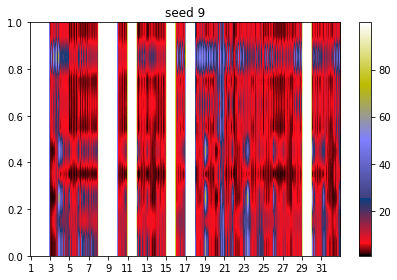

(array([[347.,  27.,   6.,   4.,   0.,   0.,   0.,   0.,   0., 128.],
        [108., 114.,  77.,  30.,  12.,  31.,   9.,   2.,   1., 128.],
        [338.,  34.,   7.,   3.,   2.,   0.,   0.,   0.,   0., 128.],
        [295.,  58.,  18.,   9.,   3.,   1.,   0.,   0.,   0., 128.],
        [332.,  37.,   7.,   4.,   2.,   2.,   0.,   0.,   0., 128.],
        [223., 105.,  34.,  12.,   5.,   3.,   1.,   1.,   0., 128.],
        [367.,  11.,   5.,   1.,   0.,   0.,   0.,   0.,   0., 128.],
        [242.,  80.,  26.,  15.,   9.,   4.,   4.,   3.,   1., 128.],
        [196., 156.,  22.,   8.,   2.,   0.,   0.,   0.,   0., 128.],
        [203.,  96.,  32.,  24.,  16.,   9.,   4.,   0.,   0., 128.]]),
 array([ 0.9889086, 10.890014 , 20.791119 , 30.692225 , 40.59333  ,
        50.494434 , 60.395542 , 70.296646 , 80.197754 , 90.098854 ,
        99.99996  ], dtype=float32),
 <a list of 10 Lists of Patches objects>)

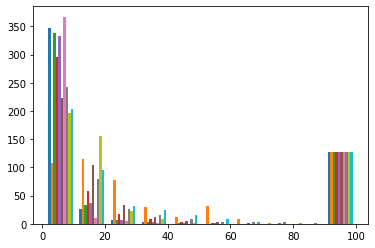

In [26]:
plt.imshow(FMNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

plt.hist(FMNIST_NN_Std_prec_00001[4])

In [32]:
"""
mnist_number = 9
linear_layer_index = 4 #linear layer has index 4
linear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

#plot setup
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

#iterate through the features and plot them
for i in range(len(layer_split)):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    axs[i].imshow(layer_split[i])
    axs[i].set_title('feature '+str(i+1))
"""

"\nmnist_number = 9\nlinear_layer_index = 4 #linear layer has index 4\nlinear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]\n\n#reshape the flattened array to 32* (4x4)\nlayer_split = np.array_split(np.array(linear_layer), 32)\nfor i in range(len(layer_split)-1):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n\n#plot setup\nfig, axs = plt.subplots(4,8, figsize=(20, 15))\nfig.subplots_adjust(hspace = .001, wspace=.001)\naxs = axs.ravel()\n\n#iterate through the features and plot them\nfor i in range(len(layer_split)):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n    axs[i].imshow(layer_split[i])\n    axs[i].set_title('feature '+str(i+1))\n"

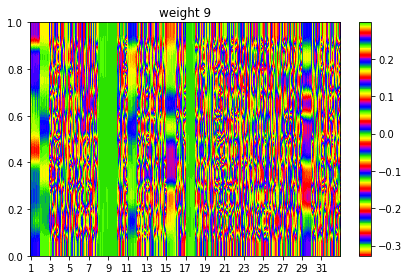

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 1., 0., 0.]]),
 array([-0.32747325, -0.2649133 , -0.20235334, -0.1397934 , -0.07723344,
        -0.01467349,  0.04788647,  0.11044642,  0.17300637,  0.23556633,
         0.29812628], dtype=float32),
 <a list of 512 Lists of Patches objects>)

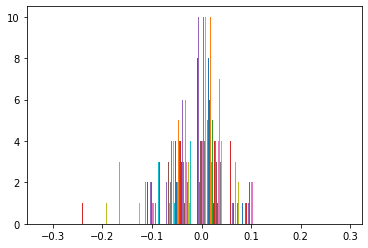

In [27]:
for name, parameters in fmnist_model.named_parameters():
    if name == '7.weight':
        a = parameters

b = a.detach().numpy()

plt.imshow(b, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
plt.hist(b)

(array([[ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1.,  0.,  0., 14.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 13.,  2.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.]]),
 array([-1.4030835e-05, -1.1935416e-05, -9.8399987e-06, -7.7445802e-06,
        -5.6491617e-06, -3.5537437e-06, -1.4583254e-06,  6.3709274e-07,
         2.7325109e-06,  4.8279294e-06,  6.9233474e-06], dtype=float32),
 <a list of 10 Lists of Patches objects>)

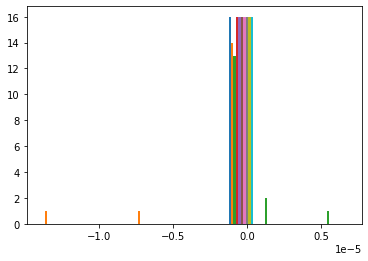

In [88]:
to_hist = []
target_feature = 9
for i in range(10):
    weight = a[i].detach().numpy()
    weight = np.array_split(np.array(weight), 32)
    to_hist.append(weight[target_feature -1])
plt.hist(to_hist)

In [87]:
"""
observe = [1, 8, 13, 14, 17, 24]
f,c = plt.subplots(3,2)
plt.figure(figsize=(20,20))
c = c.ravel()
for i in range(10):
    test = np.array_split(a[i].detach().numpy(), 32)
for idx, ax in enumerate(c):
    ax.set_title(str(observe[idx] +1))
    ax.hist(test[observe[idx]])
plt.tight_layout()
        
    
#for idx,ax in enumerate(a):
 #   ax.hist(test[observe[idx]])
 """

'\nobserve = [1, 8, 13, 14, 17, 24]\nf,c = plt.subplots(3,2)\nplt.figure(figsize=(20,20))\nc = c.ravel()\nfor i in range(10):\n    test = np.array_split(a[i].detach().numpy(), 32)\nfor idx, ax in enumerate(c):\n    ax.set_title(str(observe[idx] +1))\n    ax.hist(test[observe[idx]])\nplt.tight_layout()\n        \n    \n#for idx,ax in enumerate(a):\n #   ax.hist(test[observe[idx]])\n '